## Mechanisms of Action (MoA) Prediction

This project predicts 206 targets of the Mechanism of Action (MoA) response(s) of different samples, given 875 features such as gene expression data and cell viability data. Features g- signify gene expression data, and c- signify cell viability data. cp_type indicates samples treated with a compound (cp_vehicle) or with a control perturbation (ctrl_vehicle); control perturbations have no MoAs; cp_time and cp_dose indicate treatment duration (24, 48, 72 hours) and dose (high or low). The training data includes 2,3814 unique samples ("sig_id").

* Investigate and prepare data
* Train models
* Thoughts before implementing Random Forest Classifier

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib
from collections import Counter
import matplotlib.pyplot as plt
#store plots in notebook
%matplotlib inline 

#feature engineering
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from skmultilearn.adapt import MLkNN
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from scipy import sparse

### Investigate and prepare data
In this section, I check the sparsity and distribution of features/classes, outliers in labels, missing values and feature correlations; then, convert character features to binary indicators with Label-Encoder for tree algorithms.

In [2]:
#import training data
train_features = pd.read_csv("/Users/qingchuanlyu/Documents/Application/Projects/Mechanisms of Action (MoA) Prediction/lish-moa/train_features.csv")
train_targets_scored = pd.read_csv("/Users/qingchuanlyu/Documents/Application/Projects/Mechanisms of Action (MoA) Prediction/lish-moa/train_targets_scored.csv")

In [3]:
train_targets_scored.head(5)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
#check samples are unique in training data
len(train_features.loc[train_features['sig_id'].duplicated()==True]), len(train_targets_scored[train_targets_scored['sig_id'].duplicated()==True])
#all samples are unique in the training data

(0, 0)

In [5]:
#check if a sample could be classified as more than 1 labels
train_targets_scored['count_class'] = train_targets_scored.drop('sig_id', axis = 1).sum(axis=1)

In [6]:
train_targets_scored.loc[train_targets_scored.count_class>1][['sig_id', 'count_class']]
#1,915 samples have multiple labels: 1/10 of training data

,sig_id,count_class
2,id_000a6266a,3
11,id_0024bcd70,2
16,id_002fb9c19,2
18,id_003603254,4
21,id_003b43239,2
...,...,...
23727,id_ff1d43f96,2
23732,id_ff24fc052,2
23776,id_ff9d0a022,2
23791,id_ffd1fd119,2


In [7]:
#check all labels are binary (0 or 1): yes
(train_targets_scored.drop(['sig_id', 'count_class'], axis=1).isin([0, 1]).all()).all()
#df.any(): Return whether any element is True, potentially over an axis
#df.all(): Return whether all elements are True, potentially over an axis, default axis is 0 (row)

True

[Text(0.5, 1.0, 'Number of samples with multiple classes')]

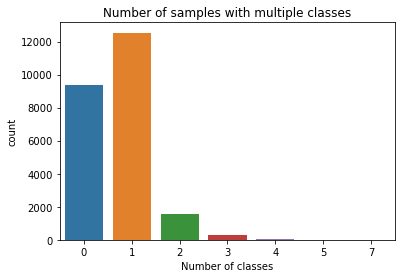

In [8]:
#plot how many samples have multiple classes
ax = sns.countplot(x ='count_class', data = train_targets_scored)
ax.set(xlabel = 'Number of classes')
ax.set(title='Number of samples with multiple classes')
#almost half of training data didn't have any class
#most samples only have one class

In [9]:
#check which of 206 classes is the most popular, and which doesn't have any sample marked
count_samples = train_targets_scored.drop(['sig_id', 'count_class'], axis = 1).sum(axis = 0)
#save it as a df
df_count_samples = pd.DataFrame({'Classes':count_samples.index, 'Count':count_samples.values})

In [10]:
df_count_samples

,Classes,Count
0,5-alpha_reductase_inhibitor,17
1,11-beta-hsd1_inhibitor,18
2,acat_inhibitor,24
3,acetylcholine_receptor_agonist,190
4,acetylcholine_receptor_antagonist,301
...,...,...
201,ubiquitin_specific_protease_inhibitor,6
202,vegfr_inhibitor,170
203,vitamin_b,26
204,vitamin_d_receptor_agonist,39


Text(0, 0.5, 'Number of Samples')

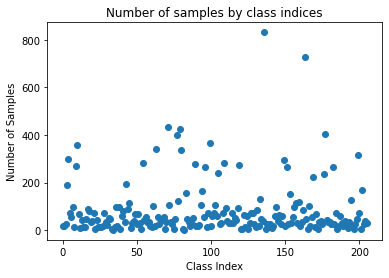

In [11]:
#plot the number of samples classified in each label
plt.scatter(df_count_samples.index, df_count_samples.Count)
plt.title("Number of samples by class indices")
plt.xlabel("Class Index")
plt.ylabel("Number of Samples")
#most classes have less than 100 samples.
#two outliers above 600
#imbalanced classes

In [12]:
#two outliers from the above plot
df_count_samples.loc[df_count_samples.Count > 600]

,Classes,Count
136,nfkb_inhibitor,832
163,proteasome_inhibitor,726


In [13]:
#Are samples classified as outliers often also classified as sth else, or just these two outliers?
len(train_targets_scored.loc[(train_targets_scored.nfkb_inhibitor>0) & (train_targets_scored.count_class>1)])/ len(train_targets_scored.loc[train_targets_scored.nfkb_inhibitor>0])
#most are calssified into more than 1 class. Take a look at other classes below

0.9134615384615384

In [14]:
first_outlier = train_targets_scored.drop(['sig_id', 'count_class'], axis=1).loc[train_targets_scored.nfkb_inhibitor>0].sum(axis = 0)
df_first_outlier = pd.DataFrame({'Classes':first_outlier.index, 'Count':first_outlier.values})

In [15]:
#other classes that come with the most popular label
df_first_outlier.loc[df_first_outlier.Count >0]
#The two outliers indeed come together very often:
#out of 832 sample classified as nfkb_inhibitor, 718 samples were also classified as proteasome_inhibitor (another outlier)

,Classes,Count
1,11-beta-hsd1_inhibitor,6
5,acetylcholinesterase_inhibitor,6
11,akt_inhibitor,6
31,apoptosis_stimulant,6
36,atpase_inhibitor,6
47,bcl_inhibitor,6
71,cyclooxygenase_inhibitor,12
72,cytochrome_p450_inhibitor,6
112,ikk_inhibitor,6
124,lipoxygenase_inhibitor,6


In [16]:
#any sample has no class in the training data?
train_targets_scored.loc[train_targets_scored.count_class==0]
#9,367 samples are classified as none of targets

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,count_class
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,id_001bd861f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,id_00224bf20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,id_002d31e2c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23801,id_fff26b3c2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23804,id_fff506720,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23806,id_fff790a17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
#any target has no sample classified into?
df_count_samples.loc[df_count_samples.Count == 0]
#all targets have at least one sample in it

,Classes,Count


In [18]:
#check correlation among labels
correlations = train_targets_scored.drop(['sig_id', 'count_class'], axis = 1).corr()

In [19]:
#check label independence
corr_unstack = correlations.unstack()
#don't think any two labels will have 100% correlation according to count_class variable, so use drop_duplicates should be fine here
corr_st = corr_unstack.sort_values(kind="quicksort").drop_duplicates()
corr_st[-11:-1]
#if consider >0.5 correlation as being highly correlated, five pairs of labels are highly correlated
#most correlation between 875 features is less than 0.33, so PCA will not do much here

fgfr_inhibitor                    vegfr_inhibitor                      0.333914
serotonin_reuptake_inhibitor      norepinephrine_reuptake_inhibitor    0.341511
insulin_sensitizer                ppar_receptor_agonist                0.402977
caspase_activator                 apoptosis_stimulant                  0.403381
nrf2_activator                    nitric_oxide_production_inhibitor    0.407888
aldehyde_dehydrogenase_inhibitor  trpv_agonist                         0.528950
pdgfr_inhibitor                   flt3_inhibitor                       0.705119
kit_inhibitor                     flt3_inhibitor                       0.758112
pdgfr_inhibitor                   kit_inhibitor                        0.915603
nfkb_inhibitor                    proteasome_inhibitor                 0.921340
dtype: float64

In [20]:
#check missing values in targets
train_targets_scored[train_targets_scored.isnull().any(axis=1)]

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,count_class


In [21]:
#check missing values in features
train_features[train_features.isnull().any(axis=1)]

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99


In [22]:
#drop id and count_class cols for training
train_targets_scored = train_targets_scored.drop('count_class', axis = 1)
train_features = train_features.drop('sig_id', axis = 1)

In [23]:
#check columns with categorical features
cats = train_features.select_dtypes(include = ['object'])
cats

,cp_type,cp_dose
0,trt_cp,D1
1,trt_cp,D1
2,trt_cp,D1
3,trt_cp,D1
4,trt_cp,D2
...,...,...
23809,trt_cp,D2
23810,trt_cp,D2
23811,ctl_vehicle,D2
23812,trt_cp,D1


In [24]:
#check how many categories cp_type and cp_dose have. If many, will not use tree algorithms
len(train_features.groupby('cp_type')), len(train_features.groupby('cp_dose'))
#only two categories for each. can use trees

(2, 2)

In [25]:
#label encoding for tree growth
for c in cats:
    lbl = LabelEncoder() 
    lbl.fit(list(train_features[c].values)) 
    train_features[c] = lbl.transform(list(train_features[c].values))

In [26]:
train_features[['cp_type', 'cp_dose']]

,cp_type,cp_dose
0,1,0
1,1,0
2,1,0
3,1,0
4,1,1
...,...,...
23809,1,1
23810,1,1
23811,0,1
23812,1,0


In [27]:
#check sparsity of features
features_nonzero_ct = (train_features != 0).sum(0)
#imbalanced data with many features mostly populated with 1 other than 0.

In [28]:
features_nonzero_counts = pd.DataFrame({'feature_name': features_nonzero_ct.index, 'nonzero_ct': features_nonzero_ct.values})

[]

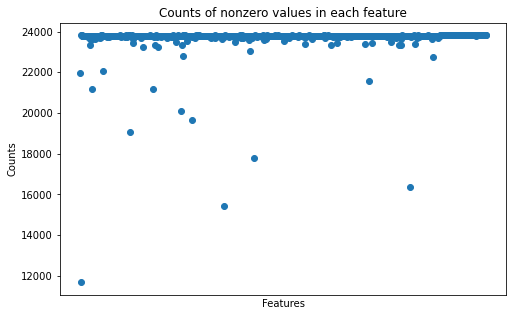

In [29]:
#plot the counts of 1 in each feature
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(features_nonzero_counts['feature_name'], features_nonzero_counts['nonzero_ct'])
ax.set_title('Counts of nonzero values in each feature')
ax.set_xlabel('Features')
ax.set_ylabel('Counts')
ax.get_xaxis().set_ticks([])
#nonzero values dominate features=> biases tree growth

In [30]:
y_train = train_targets_scored.drop('sig_id', axis=1).values

### Train Models

In this section, I train Random Forest, K-Nearest-Neighborhood, Multi-K-Nearest-Neighborhood and Multi-Layer Perception algorithms for this multilabel classification problem. 

In [36]:
#random forest
rdf = RandomForestClassifier(max_depth=2, n_estimators=100, class_weight = 'balanced', random_state=1)
param_grid={
            'max_depth': range(2,4),
            'n_estimators': [50, 100],
            'class_weight': 'balanced'
        }
search_rdf = GridSearchCV(estimator = rdf, param_grid=param_grid, cv = 3, n_jobs=-1)   

In [37]:
#fit model
search_rdf.fit(train_features, y_train)
print(f"{search_rdf.best_params_}")

{'max_depth': 3, 'n_estimators': 100}


In [38]:
#predict the probability for each sample
#for each label, predict_proba gives two probabilities (classified as 0 or 1) and they sum to 1
search_rdf_probs = search_rdf.predict_proba(train_features)

In [133]:
#extract the predicted probability for classifying as 1 rather than 0
#then transform to be a flat array
pred_proba_rdf = []
for i in search_rdf_probs:
    j = list(zip(*i))
    pred_proba_rdf.append(j[1])
#compute cross-entropy
log_loss(np.ravel(y_train), np.ravel(pred_proba_rdf))

0.02736040936327625

In [ ]:
#random forest cv = 5: accuracy 0.4213 with 100 trees 
#random forest cv = 3: accuracy 0.4212 with 50 trees

In [40]:
#k-nearest neighborhood
#how to select k (# neighbors): too small could subject to outliers
neigh = KNeighborsClassifier(n_neighbors=5)
param_grid_neigh={
            'n_neighbors': [5, 50]
        }
search_neigh = GridSearchCV(estimator = neigh, param_grid = param_grid_neigh, cv = 3, n_jobs=-1)   
search_neigh.fit(train_features, y_train)
print(f"{search_neigh.best_params_}")

{'n_neighbors': 5}


In [134]:
#predict the probability for each sample
#for each label, predict_proba gives two probabilities (classified as 0 or 1) and they sum to 1
search_neigh_probs = search_neigh.predict_proba(train_features)
#extract the predicted probability for classifying as 1 rather than 0
#then transform to be a flat array
pred_proba_neigh = []
for i in search_neigh_probs:
    j = list(zip(*i))
    pred_proba_neigh.append(j[1])
#compute cross-entropy
log_loss(np.ravel(y_train), np.ravel(pred_proba_neigh))

0.13638601925017188

In [ ]:
#knn=> k = 5, cv=3: accuracy 0.4693

In [41]:
#mlp optimizes the log-loss function with stochastic gradient descent
#uses adam optimizer by default
mlp = MLPClassifier(learning_rate_init=.001, 
                    max_iter=300, 
                    activation = 'relu',
                    random_state=1)
param_grid_mlp={
                'learning_rate_init': (.001, .01), 
                #number of data points will be used (if reached before convergence)
                'max_iter': (300, 350), 
                'activation': ('tanh', 'relu')
                }
search_mlp = GridSearchCV(estimator = mlp, param_grid = param_grid_mlp, cv = 3, n_jobs=-1)   
search_mlp.fit(train_features, y_train)
print(f"{search_mlp.best_params_}")

{'activation': 'tanh', 'learning_rate_init': 0.01, 'max_iter': 300}


In [138]:
#predict the probability for each sample
#mlp returns a 23814 * 206 array, and therefore I don't have to do any transformation as before
search_mlp_probs = search_mlp.predict_proba(train_features)
log_loss(np.ravel(y_train), np.ravel(search_mlp_probs))

0.004787300733423332

In [ ]:
#mlp=> cv=3: accuracy 0.3956 with {'activation': 'tanh', 'learning_rate_init': 0.01, 'max_iter': 300}

In [132]:
#MLKNN classifier is an upgraded version of KNN by using MAP and sparse matrices
ml_knn = MLkNN(k=5)
param_grid_ml_knn={
                    'k': [5, 50]
                    }
search_mlknn = GridSearchCV(estimator = ml_knn, param_grid = param_grid_ml_knn, cv = 3, n_jobs=-1)   
search_mlknn.fit(train_features, y_train)
print(f"{search_mlknn.best_params_}")

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_neighbors=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{'k': 5}


In [149]:
#predict the probability for each sample
#mlknn returns a 23814 * 206 array, and therefore I don't have to do any transformation as before
search_mlknn_probs = search_mlknn.predict_proba(train_features)
#compute cross-entropy
log_loss(np.ravel(y_train), np.ravel(sparse.lil_matrix(search_mlknn_probs).toarray()))

0.01911127113904523

### Thoughts before implementing Random Forest Classifier:

Used only for comparison purposes, as features are not balanced (before I calculated that almost all features have 1 other than 0). This leads trees to grow in the direction of 1 and have a long runtime.
* Highly correlated features:

 * High collinearity is a problem in causal inference with impurity based feature selection, because an important feature might be viewed as unimportant when another highly correlated feature already takes care of impurity. Random selection of features doesn't completely cancel out this problem.

 * However, high collinearity between a couple of features doesn't hurt the predictive power of random forests: high collinearity doesn't decrease information stored within features, and a feature highly correlated with another may still be useful unless they're perfectly correlated. Therefore, I included highly correlated features here (five pairs of features as seen before)

* Direction of trees' growth:

As each feature is binary (character features only have two categories, too), I don't need to worry about a feature with too many categories that will biase trees' growth direction. Meantime, the imbalance of features is a real concern. As the graph shows, most features were recorded 1 for almost all samples, while only five pairs of features were highly correlated (corr > 0.5). However, it is a dense training set with the majority of features populated as 1 most of time. This will make trees grow in the direction of 1. Later I might try algorithms less affected by imbalanced features, such as XGBoost. XGBoost doesn't work for multilabel problems naturally and requires a bit of work.

* scoring metrics 

Mean accuracy (the default scoring metric of multilabel classifiers from sklearn) only counts samples with all 206 labels predicted correctly--a bit harsh. I will use log loss (cross-entropy) with predicted probabilities instead. Similar to accuracy, log loss evaluates the performance over all labels. However, log loss is affected by the balance of data. As training data becomes more imbalanced, log loss decreases more by design. In this case where a class has 1/30 of samples at most, log loss is expected to be low.